# Synchronizing Tracking and Event Data

## Introduction

Tracking and event data in itself are interesting, but for tacitcal analysis, it is very useful to synchronise the two. Synchronising tracking data to events is commonly done to add context to events. For instance, shooting on goal when there are 5 defenders in front of the goal is a lot harder than when there is only the goalkeeper. The quality of the synchronisation is really crucial for the quality of the analysis. If the synchronisation is off, two defenders might be added in the example above, which would make the shooting situation seem a lot worse than it actually was. However, in articles, the synchronisation is often not elaborated on. Lets explore some key difficulties in synchronising tracking and event data when the data providers are different.

1. **Different Datetimes**: This seems like the perfect way to go, but sadly, the datetimes in the tracking and event data do often not align perfectly. The event data is often recorded partially manually, so delay in broadcasting, human error, etc. can cause the datetimes to be off.

2. **Different Locations**: In event data you know the location of the event, and you know the location of the players and the ball in the tracking data. However, also these do not seem to be very closely related. 

3. **Who is Right?**: Since data providers are quite closed on how the data is collected, and there is no golden standard, it is hard to say who is right. The tracking data might be off, but the event data might be off as well. Furthermore, there are no clear definitions on what is the exact moment of a dribble or a tackle, or if you think it is a time period instead of a moment, when does this period start and end? Lastly, there is no 'perfect' dataset to which you can compare different approaches.

In this notebook we will show differen approaches of how to synchronise tracking and event data. In total 3 solutions will be expolored. Firstly, we will look at a naive approach of just taking the timestamp of the event and finding the closest timestamp in the tracking data. Secondly, we will use the most common approach, which the use of a cost or objective function in a time window. Lastly, we will show the use of a NeedleMan Wunch Algorithm to synchronise the data as is proposed by [this](https://kwiatkowski.io/sync.soccer) blogpost.

```python
from databallpy import get_match, get_open_match

match = get_match(
  tracking_data_loc="../data/tracking_data.dat",
  tracking_metadata_loc="../data/tracking_metadata.xml",
  tracking_data_provider="tracab"
  event_data_loc="../data/event_data_f24.xml",
  event_metadata_loc="../data/event_metadata_f7.xml",
  event_data_provider="opta",
)

# or get the open match provided by Metrica
match = get_open_match()
```

```{note}
The current supported tracking data providers are:

- Tracab
- Metrica
- Inmotio

The current supported event data provider are:
- Opta
- Metrica
- Instat

If you wish to use a different provider that is not listed here, please open an issue [here](https://github.com/Alek050/databallpy/issues)
```


In [1]:
import os
from databallpy import get_saved_match
from databallpy.features import add_velocity, add_acceleration

match = get_saved_match(os.path.join(os.getcwd(), "..", "saved_matches", "not_synced_match.pickle"))

match.tracking_data = add_velocity(match.tracking_data, ["ball"], match.frame_rate, filter_type="savitzky_golay", window_length=5, polyorder=2)
match.tracking_data = add_acceleration(match.tracking_data, ["ball"], match.frame_rate, filter_type="savitzky_golay", window_length=25, polyorder=2)

from databallpy.utils.constants import MISSING_INT
import pandas as pd
event_data = match.event_data.iloc[15:25].copy()
tackle = {
    "event_id":2504471412, 
    "type_id":7, 
    "databallpy_event": "tackle", 
    "period_id": 1, 
    "minutes": 0, 
    "seconds": 38, 
    "player_id": match.home_players.loc[match.home_players["shirt_num"]==8, "id"].values[0],
    "team_id": match.home_team_id,
    "outcome": MISSING_INT,
    "start_x": -7.9329,
    "start_y": 18.2203,
    "datetime": pd.to_datetime("1980-01-01 15:00:40.110000+00:00"),
    "opta_event": "tackle",
    "opta_id": 17,
    "player_name": "home_8",
    }
event_data = pd.concat([event_data, pd.DataFrame([tackle])])

wrong_pass = {
    "event_id":9999999999, 
    "type_id":7, 
    "databallpy_event": "pass", 
    "period_id": 1, 
    "minutes": 0, 
    "seconds": 32, 
    "player_id": match.away_players.loc[match.home_players["shirt_num"]==1, "id"].values[0],
    "team_id": match.away_team_id,
    "outcome": MISSING_INT,
    "start_x": 35.5699,
    "start_y": 3.8403,
    "datetime": pd.to_datetime("1980-01-01 15:00:33.836000+00:00"),
    "opta_event": "pass",
    "opta_id": 999,
    "player_name": "away_1",
}
event_data = pd.concat([event_data, pd.DataFrame([wrong_pass])])

event_data.index = [15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 23, 17]
event_data = event_data.sort_index()

match.tracking_data = match.tracking_data.loc[600:1100]
match.event_data = event_data

match._is_synchronised = True

## The Data

Lets first have look at the data. To exemplify the different methods, I will showcase a short part of a match with a few events which we will use for the all three different methods. The same pricinples apply for a full match, but it is easier to understand what is happening by looking at a short part of the match. 

In [16]:
from databallpy.visualize import save_tracking_video

# save_tracking_video(
#     match,
#     600,
#     1100,
#     os.path.join(os.getcwd(), "..", "static"),
#     title="tracking_sync"
# )

from IPython.display import Video
Video(os.path.join(os.getcwd(), "..", "static", "tracking_sync.mp4"), embed=True, width=800)



In [126]:
match.event_data

event_id  type_id databallpy_event  period_id  minutes  seconds  \
15  2504410107        1             pass          1        0       28   
16  2504410179        1             pass          1        0       29   
17  9999999999        7             pass          1        0       32   
18  2504410187       44             None          1        0       35   
19  2504410195       44             None          1        0       35   
20  2504410191       61             None          1        0       36   
21  2504411469       61             None          1        0       36   
22  2504471349       49             None          1        0       37   
23  2504471412        7           tackle          1        0       38   
24  2504471411        1             pass          1        0       38   
25  2504410251        1             pass          1        0       39   
26  2504410257        4             None          1        0       40   

     player_id     team_id  outcome  start_x  start_y  \
15  P-eb2fc2c0  T-2966d799        1 -36.6101  33.9000   
16  P-a9218506  T-2966d799        1 -37.5542  32.7474   
17  P-ae53aaf0  T-8fe7ca67     -999  35.5699   3.8403   
18  P-57720512  T-2966d799     -999 -10.1753  21.8316   
19  P-2029d951  T-8fe7ca67     -999 -10.1753  21.8316   
20  P-57720512  T-2966d799     -999  -9.6508  23.1876   
21  P-2029d951  T-8fe7ca67     -999  -8.7067  14.7126   
22  P-91975481  T-8fe7ca67     -999  -9.1263  17.8314   
23  P-86065143  T-2966d799     -999  -7.9329  18.2203   
24  P-91975481  T-8fe7ca67        0  -8.0773  18.7806   
25  P-1bb146b1  T-2966d799        0 -23.1829   6.9834   
26  P-86065143  T-2966d799     -999  -4.1960   6.3732   

                           datetime     opta_event  opta_id player_name  
15 1980-01-01 15:00:30.761000+00:00           pass        8      home_3  
16 1980-01-01 15:00:31.866000+00:00           pass        9     home_10  
17 1980-01-01 15:00:33.836000+00:00           pass      999      away_1  
18 1980-01-01 15:00:38.042000+00:00         aerial       10     home_11  
19 1980-01-01 15:00:38.043000+00:00         aerial        9      away_2  
20 1980-01-01 15:00:38.634000+00:00     ball touch       11     home_11  
21 1980-01-01 15:00:38.912000+00:00     ball touch       16      away_2  
22 1980-01-01 15:00:39.330000+00:00  ball recovery      377      away_8  
23 1980-01-01 15:00:40.110000+00:00         tackle       17      home_8  
24 1980-01-01 15:00:40.330000+00:00           pass      378      away_8  
25 1980-01-01 15:00:41.955000+00:00           pass       12      home_5  
26 1980-01-01 15:00:42.660000+00:00           foul       13         NaN

So we see here a situation with 2 passes, followed by an arial. Away 8 picks up the ball, passes is, but is tackled by home 8. Home 5 still gets to pass the ball, but the ref blows for a foul from home 8 on away 8. For the following methods, we will only focus on the passes and tackles for precise synchronisation. Also notice the wrongly labelled event (pass by away_1). Sometimes event data annotates events that did not really happen. It is important to see what happens to these events in different types of synchonisations. The pass of th away goalkeeper did of course not happen here.

## Synchronisation by datetimes

As a first methods we will try to synchronise the events, only by datetimes. This is the easiest approach since we know the datetimes of all events and frames in the tracking data. The question is, will it give us a good synchronisation?

In [3]:
EVENTS_OF_INTEREST = ["pass", "tackle"]
event_data_mask = match.event_data["opta_event"].isin(EVENTS_OF_INTEREST)

match.tracking_data["event_id"] = None
match.tracking_data["databallpy_event"] = None
for i, event in match.event_data.loc[event_data_mask].iterrows():
    event_id = event["event_id"]
    event_datetime = event["datetime"]
    tracking_idx = match.tracking_data["datetime"].sub(event_datetime).abs().idxmin()
    match.tracking_data.loc[tracking_idx, "event_id"] = event_id
    match.tracking_data.loc[tracking_idx, "databallpy_event"] = event["databallpy_event"]

In [17]:
# save_tracking_video(
#     match,
#     600,
#     1100,
#     os.path.join(os.getcwd(), "..", "static"),
#     title="tracking_sync_datetime1",
#     events=EVENTS_OF_INTEREST,
# )

from IPython.display import Video
Video(os.path.join(os.getcwd(), "..", "static", "tracking_sync_datetime1.mp4"), embed=True, width=800)

````{margin}
```{note}
The red crosses indicates the location of the event according to the event data. The moment the cross is visible, the tracking data stops to show you how it is timed according the the synchronisation method.
```
````

Hmmm that looks like it is lacking quite a bit. But maybe it is a constant bias. Maybe if we correct the datatime for the start of the match, we can see better what is happening. A constant bias should not be a big problem to solve. Lets try that.

In [8]:
start_datetime_td = match.periods.loc[0, "start_datetime_td"]
start_datetime_ed = match.periods.loc[0, "start_datetime_ed"]
constant_time_bias = start_datetime_ed - start_datetime_td

print(f"Start datetime tracking data: {start_datetime_td}")
print(f"Start datetime event data: {start_datetime_ed}")
print(f"Time difference: {constant_time_bias}")

match.tracking_data["event_id"] = None
match.tracking_data["databallpy_event"] = None
for i, event in match.event_data.loc[event_data_mask].iterrows():
    event_id = event["event_id"]
    event_datetime = event["datetime"] - constant_time_bias
    tracking_idx = match.tracking_data["datetime"].sub(event_datetime).abs().idxmin()
    match.tracking_data.loc[tracking_idx, "event_id"] = event_id
    match.tracking_data.loc[tracking_idx, "databallpy_event"] = event["databallpy_event"]

Start datetime tracking data: 1980-01-01 15:00:00+00:00
Start datetime event data: 1980-01-01 15:00:01.880000+00:00
Time difference: 0 days 00:00:01.880000


In [18]:
import numpy as np
# save_tracking_video(
#     match,
#     600,
#     1100,
#     os.path.join(os.getcwd(), "..", "static"),
#     title="tracking_sync_datetime2",
#     events=EVENTS_OF_INTEREST,
#     verbose=False
# )

from IPython.display import Video
Video(os.path.join(os.getcwd(), "..", "static", "tracking_sync_datetime2.mp4"), embed=True, width=800)

Well this definately looks a bit better, but you can clearly see that it is still off quite a bit. Also, you see that it is not a constant error. If you look closesly, the time difference for the first pass (home_3) is quite a bit shorter than the last pass (home_5). This is because the time difference is not constant. Lastly, using this approach, it is hard to consider which events might be wrongly labelled. Sadly, using only datetime is not enough to get a propper synchronisation of the tracking and event data. Lets try a different approach.

## Synchronisation by cost functions

The most common approach to synchronise tracking and event data is by using an cast function. This cost function is used to calculate the difference between the tracking data and the event data information. For instance, because of the datetimes, we know roughly when an event is happening. We also know the location of the event in the event data, and the location of the ball and the player involved in the tracking data. Lastly, we know a little information about what generally happens during an event. For instance, a pass is often accompanied by acceleration of the ball. Lets create some custom cost functions.

````{margin}
```{note}
The KU Leuven Football Analytics group also implemented a similar approach called [ETSY](https://github.com/ML-KULeuven/ETSY). This is a great resource if you are interested in the topic.
```
````

For the pass:
- difference in datetimes
- distance between the event location and ball location
- distance between the ball location and the player location
- acceleration of the ball
- increase in distance between the player and the ball

For the tackle:
- difference in datetimes
- distance between the event location and ball location
- distance between the ball location and the player location

To make sure all these features are in the same scale, we will normalize them using a sigmoid function. Lets see how this works out.


In [9]:
from databallpy.utils.utils import sigmoid

def get_time_difference_cost(tracking_datetime, event_datetime):
    time_diff = (tracking_datetime - event_datetime).dt.total_seconds()
    return sigmoid(np.abs(time_diff), e=5)

def get_distance_ball_event_cost(tracking_data, event):
    distance = np.hypot(
        tracking_data["ball_x"].values - event["start_x"], 
        tracking_data["ball_y"].values - event["start_y"]
        )
    return sigmoid(distance, d=5, e=6)

def get_distance_ball_player_cost(tracking_data, player_column_id):
    distance = np.hypot(
        tracking_data["ball_x"].values - tracking_data[player_column_id + "_x"].values, 
        tracking_data["ball_y"].values - tracking_data[player_column_id + "_y"].values
        )
    return sigmoid(distance, d=5, e=2.5)

def get_ball_acceleration_cost(tracking_data):
    return sigmoid(-tracking_data["ball_acceleration"].values, d=0.2, e=-25.0)

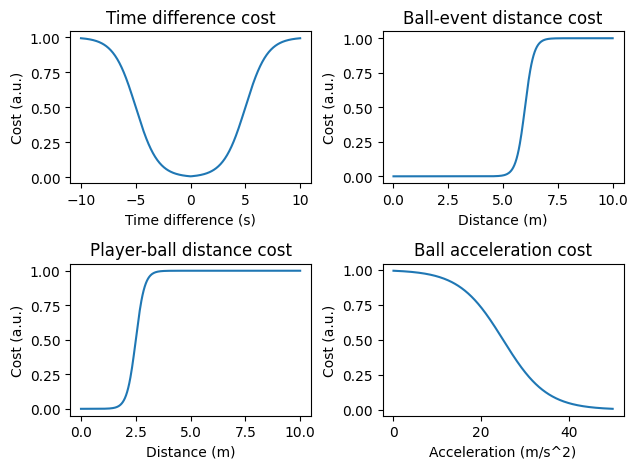

In [11]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
time_diff = np.linspace(-10, 10, 400)
ax1.plot(time_diff, sigmoid(np.abs(time_diff), e=5))
ax1.set_title("Time difference cost")
ax1.set_xlabel("Time difference (s)")
ax1.set_ylabel("Cost (a.u.)")

ball_event_distance = np.linspace(0, 10, 400)
ax2.plot(ball_event_distance, sigmoid(ball_event_distance, d=5, e=6))
ax2.set_title("Ball-event distance cost")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Cost (a.u.)")

player_ball_distance = np.linspace(0, 10, 400)
ax3.plot(player_ball_distance, sigmoid(player_ball_distance, d=5, e=2.5))
ax3.set_title("Player-ball distance cost")
ax3.set_xlabel("Distance (m)")
ax3.set_ylabel("Cost (a.u.)")

ball_acceleration = np.linspace(0, 50, 400)
ax4.plot(ball_acceleration, sigmoid(-ball_acceleration, d=0.2, e=-25.0))
ax4.set_title("Ball acceleration cost")
ax4.set_xlabel("Acceleration (m/s^2)")
ax4.set_ylabel("Cost (a.u.)")

plt.tight_layout()
plt.show()

The lower the values, the better. In a perfect scenario, the datetime difference between the tracking and event data is 0, the distance between the ball and the event is 0, the distance between the player and the ball is close to 0 and the ball acceleration is high (for passes). The cost function for the time difference is bell shaped. It is also quite wide, since we already saw that the time difference between the event and the tracking data can be quite high. For the distances, we chose a more hard cut off approach. Since the ball location and the event location are from different data sources, we have to assume that they are not perfectly aligned and thus give up to 6 meters difference to be acceptable. The distance between the player and the ball is a bit more strict, since it both provided by the tracking data. Lastly, we add some extra information for passes based on the acceleration of the ball.

The great thing about these cost functions is that you can change them according how you think the synchronisation should be done. On top of that, you can optimize it if you have a labelled dataset of perfect syncronisations. Another advantage is that you can add multiple features to the total cost function, and you can weigh each feature differently since they are all normalized. Lastly, you can set thresholds for each total cost function to decide if the event is correctly synchronised or not. This will come in handy when identifying wrongly labelled events.

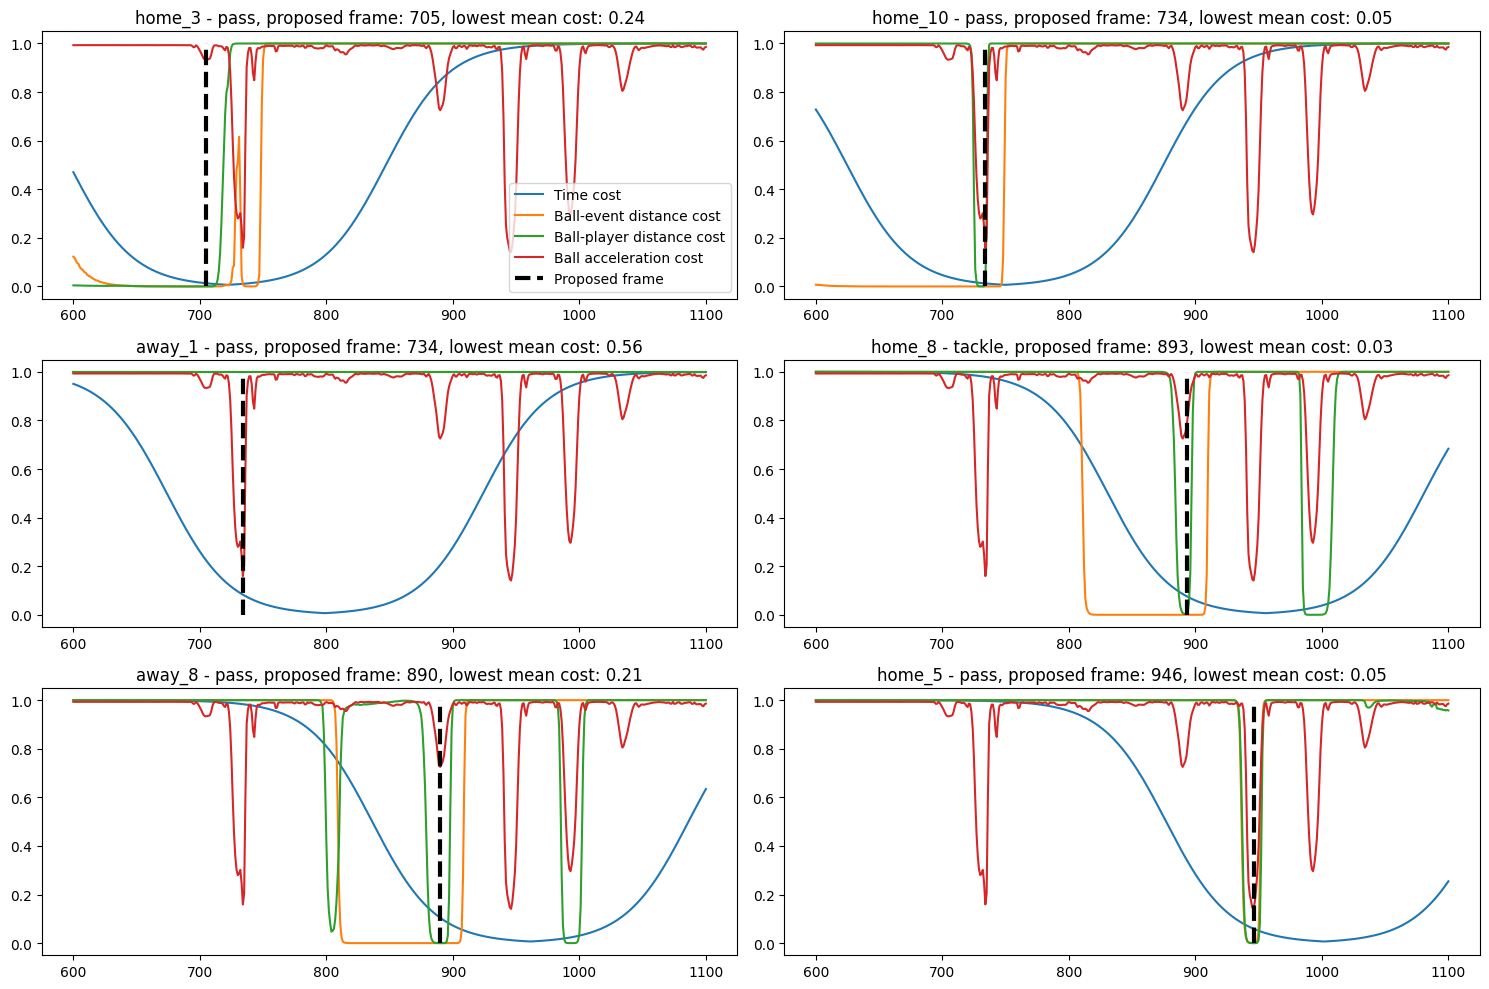

In [26]:
match.tracking_data["event_id"] = None
match.tracking_data["databallpy_event"] = None


def plot_cost_functions(ax, tracking_data, event, costs):
    time_cost, ball_event_cost, ball_player_cost, ball_acceleration_cost = costs
    ax.plot(tracking_data.index, time_cost, label="Time cost")
    ax.plot(tracking_data.index, ball_event_cost, label="Ball-event distance cost")
    ax.plot(tracking_data.index, ball_player_cost, label="Ball-player distance cost")
    ax.plot(tracking_data.index, ball_acceleration_cost, label="Ball acceleration cost")
    ax.vlines(tracking_idx, 0, 1, color="black", label="Proposed frame", linestyles="--", linewidth=3)
    ax.set_title(
        f"{event["player_name"]} - {event["databallpy_event"]}, proposed frame: "
        f"{tracking_idx}, lowest mean cost: {lowest_cost:.2f}"
        )

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for ax, (i, event) in zip(axs.ravel(), match.event_data.loc[event_data_mask].iterrows()):

    time_cost = get_time_difference_cost(
        match.tracking_data["datetime"], 
        event["datetime"] - constant_time_bias
        )
    ball_event_cost = get_distance_ball_event_cost(match.tracking_data, event)
    ball_player_cost = get_distance_ball_player_cost(
        match.tracking_data, 
        event["player_name"])
    
    ball_acceleration_cost = get_ball_acceleration_cost(match.tracking_data)
 
    total_cost = (
        time_cost + 
        ball_event_cost + 
        ball_player_cost + 
        (ball_acceleration_cost if event["databallpy_event"] == "pass" else 0)
    )
    tracking_idx = total_cost.idxmin()
    lowest_cost = (
        total_cost / (4 if event["databallpy_event"] == "pass" else 3)
        ).min()

    if lowest_cost <= 0.5:
        match.tracking_data.loc[tracking_idx, "event_id"] = event["event_id"]
        match.tracking_data.loc[tracking_idx, "databallpy_event"] = event["databallpy_event"]
    
    plot_cost_functions(
        ax, 
        match.tracking_data, event, 
        (time_cost, ball_event_cost, ball_player_cost, ball_acceleration_cost)
    )

    

axs[0][0].legend()
fig.tight_layout()
plt.show()

In [19]:
# save_tracking_video(
#     match,
#     600,
#     1100,
#     os.path.join(os.getcwd(), "..", "static"),
#     title="tracking_sync_cost",
#     events=EVENTS_OF_INTEREST,
#     verbose=False
# )

from IPython.display import Video
Video(os.path.join(os.getcwd(), "..", "static", "tracking_sync_cost.mp4"), embed=True, width=800)

Wow, that looks already a lot better! The synchronisation is pretty good. Finetuning the cost functions based on you own data can make it even better. Furthermore, you can also add more features to the cost function if you think it makes sense. For instance, for the pass you can also compute the increase in distance between the ball and the player, which close to the acceleration, but might be a better feature than the acceleration. Lets list some advantages and disadvantages of this approach.

1. Pretty good synchronisation
2. Customizable cost functions and wheights
3. Is able to identify wrongly labelled events. Did you see that the wrongly labelled pass by away_1 is not in the synchronised data? The cost function was more than twice as high as the other cost functions, thus it was not included in the synchronised data.

There is, however, one big disadvantage of this kind of approach. Did you notice the other of the events got swapped? The tackle of home_8 should be before the pass of away_8, however it is placed 4 frames later. There are not a lot of certainties in event data, but the order of the events is generally one you can rely on. This is a big disadvantage of this approach. You could, of course, add a feature to the cost function that checks if the current event is after the last event, but this assumes that the first event is properly synchronised. In this case, it looks like the tackle should be moved forwards, not the pass backwards. Lets see if the last approach can account for this.

## Synchronisation by Needleman Wunch Algorithm

The Needleman Wunch Algorithm is a sequence alignment algorithm that is often used in bioinformatics. It is used to align two sequences of characters. In this case, we will use it to align the events in the event data to the tracking data. Instead of considering each event on itself, we will put all events in a matrix and try to find the optimal path through the matrix. The optimal path will give us the best alignment of the events in the event data to the tracking data. Before we show it in the example, let us consider a very simple example with 3 events, and 6 frames. Lets also assume we know the right synchronisation. If an event corresponds to a frame, we will give it a 1. For every frame the event is off, we will substract 1.

````{margin}
```{note}
We got inspired by [this](https://kwiatkowski.io/sync.soccer) blogpost and package to implement this approach in databallpy. Really worth reading if you want to know more about this approach.
```
````


| Event | 1 | 2 | 3 |
|-------|---|---|---|
| Frame 1 | <span style="color:green">**1**</span> | -1 | -4 | 
| Frame 2 | 0 | 0 | -3 |
| Frame 3 | -1 | <span style="color:green">**1**</span> | -2 | 
| Frame 4 | -2 | 0 |-1 | 
| Frame 5 | -3 | -1 | 0 | 
| Frame 6 | -4 | -2 | <span style="color:green">**1**</span> |


In this example, optimally, event 1 is assigned to frame 1. Event 2 is assigned to frame 3, and event 3 is assigned to frame 6.

Now we know the costs for every event to every frame. We have put it in a matrix which we will call the `similarity_matrix`. The next step is to compute a `pointer_matrix`. For the `pointer_matrix` we will need to add an extra column and an extra row. In the row, we set the penalty for leaving a frame unassinged, which will be 0 since there are a lot of frame unassigned in tracking data. In the column, we set the penalty for leaving an event unassigned, which will be -1 since we do not want to leave any event unassigned. Lets initiate the `pointer_matrix`.


| Event | - | 1 | 2 | 3 |
|-------|---|---|---|---|
| - | 0 | 0 | 0 | 0 |
| Frame 1 | -1 | ... | ... | ... |
| Frame 2 | -2 | ... | ... | ... |
| Frame 3 | -3 | ... | ... | ... |
| Frame 4 | -4 | ... | ... | ... |
| Frame 5 | -5 | ... | ... | ... |
| Frame 6 | -6 | ... | ... | ... |

Now, to fill the pointer matrix, we compute the value of the cell by taking the maximum of 3 options:
1. The value of the cell above + the penalty of leaving a frame unassigned
2. The value of the cell left + the penalty of leaving an event unassigned
3. The value of the cell diagonally left above + the similarity of the event and the frame

So lets fill it in for the cell between Frame 1 and Event 1. 
1. The value of the cell above is 0, the penalty of leaving a frame unassigned is 0, so the value is 0.
2. The value of the cell left is -1, the penalty of leaving an event unassigned is -1, so the value is -2.
3. The value of the cell diagonally left above is 0, the similarity of the event and the frame is 1, so the value is 1.

The maximum of these 3 values is 1, so we fill in 1 in the cell between Frame 1 and Event 1. Lets fill in the rest of the matrix.

| Event   | -  | 1  |  2 |  3 |
|---------|----|----|----|----|
| -       | 0  | 0  | 0  |  0 |
| Frame 1 | -1 | 1  | 0  |  0 |
| Frame 2 | -2 | 1  | 1  |  0 |
| Frame 3 | -3 | 1  | 2  |  0 |
| Frame 4 | -4 | 1  | 2  |  2 |
| Frame 5 | -5 | 1  | 2  |  2 |
| Frame 6 | -6 | 1  | 2  |  3 |


In this very simple example the matrix looks rather simatrical, but with more sophisticated cost functions it will look less like this. However, for the example it is easy to go through. We have now filled the `pointer_matrix` row by row. The next step is to find the optimal path from bottom right to top left through the matrix. Again, for each step, we have 3 options:
1. Go up (leave a frame unassigned)
2. Go left (leave an event unassigned)
3. Go diagonally up left (assign the event to the frame)

Lets look at the first step:

| Event   | -  | 1  |  2 |  3 |
|---------|----|----|----|----|
| -       | ...  | ...  | ...  |  ... |
| Frame 1 | ... | ...  | ...  |  ... |
| Frame 2 | ... | ...  | ...  |  ... |
| Frame 3 | ... | ...  | ...  | ... |
| Frame 4 | ... | ...  | ...  |  ... |
| Frame 5 | ... | ...  | 2  |  2 |
| Frame 6 | ... | ...  | 2  |  <span style="color:green">**3**</span> |

In the first step all three options are equal, if this is the case, we will go diagonally to assign the frame. Thus, assigning Event 3 to Frame 6. Lets go to the next step.

| Event   | -  | 1  |  2 |  3 |
|---------|----|----|----|----|
| -       | ...  | ...  | ...  |  ... |
| Frame 1 | ... | ...  | ...  |  ... |
| Frame 2 | ... | ...  | ...  |  ... |
| Frame 3 | ... | ...  | ...  | ... |
| Frame 4 | ... | 1  | 2  |  ... |
| Frame 5 | ... | 1  | <span style="color:green">**2**</span>  |  2 |
| Frame 6 | ... | ...  | 2  |  <span style="color:green">**3**</span> |

Here we see that the optimal path is to go upwards to the two. Thus, we leave Frame 5 unassigned. Lets fill in the `pointer_matrix` for the rest of the matrix.

| Event   | -  | 1  |  2 |  3 |
|---------|----|----|----|----|
| -       | <span style="color:green">**0**</span>  | 0  | ...  |  ... |
| Frame 1 | -1 |<span style="color:green"> **1**</span>  | ...  |  ... |
| Frame 2 | -2 | <span style="color:green">**1**</span>  | 1  |  ... |
| Frame 3 | ... | 1  | <span style="color:green">**2**</span> | ... |
| Frame 4 | ... | 1  | <span style="color:green">**2**</span>  |  ... |
| Frame 5 | ... | 1  | <span style="color:green">**2**</span>  |  2 |
| Frame 6 | ... | ...  | 2  |  <span style="color:green">**3**</span> |

Since we went diagonal at locations (frame 6, event 3), (frame 3, event2), and (frame 1, event 1) this is how they are assigned. Which corresponds to our initial idea of how they should be aligned.

Okay enough theory, lets work it out in some code.

```{note}
In the example below we import the function `_needleman_wunch` which basically computes the optimal path through the matrix given some gap penalties. To keep it simple, we will not show the code here, but you can find it in the source code of databallpy.
```

In [14]:
from databallpy.utils.synchronise_tracking_and_event_data import _needleman_wunsch

match.tracking_data["event_id"] = None
match.tracking_data["databallpy_event"] = None

similarity_matrix = np.zeros((len(match.tracking_data), len(match.event_data.loc[event_data_mask])))                             
for iloc, (_, event) in enumerate(match.event_data.loc[event_data_mask].iterrows()):

    time_cost = get_time_difference_cost(match.tracking_data["datetime"], event["datetime"] - constant_time_bias)
    ball_event_cost = get_distance_ball_event_cost(match.tracking_data, event)
    ball_player_cost = get_distance_ball_player_cost(match.tracking_data, event["player_name"])
    ball_acceleration_cost = get_ball_acceleration_cost(match.tracking_data)

    total_cost = time_cost + ball_event_cost + ball_player_cost
    if event["databallpy_event"] == "pass":
        total_cost += ball_acceleration_cost
    
    mean_cost = (total_cost / 3 if event["databallpy_event"] == "pass" else total_cost / 4)

    similarity_matrix[:, iloc] = mean_cost.values

asigned_frames = _needleman_wunsch(-similarity_matrix + 1)
for iloc, (_, event) in enumerate(match.event_data.loc[event_data_mask].iterrows()):
    tracking_idx = asigned_frames[iloc]
    
    if similarity_matrix[tracking_idx, iloc] <= 0.5:
        match.tracking_data.loc[match.tracking_data.index[tracking_idx], "event_id"] = event["event_id"]
        match.tracking_data.loc[match.tracking_data.index[tracking_idx], "databallpy_event"] = event["databallpy_event"]


In [20]:
# save_tracking_video(
#     match,
#     600,
#     1100,
#     os.path.join(os.getcwd(), "..", "static"),
#     title="tracking_sync_needlewunch",
#     events=EVENTS_OF_INTEREST,
#     verbose=False
# )

from IPython.display import Video
Video(os.path.join(os.getcwd(), "..", "static", "tracking_sync_needlewunch.mp4"), embed=True, width=800)

And there it is. Now you can see that we used the advantages of the cost function approach, but also kept the order of the events in the event data. This is a big advantage of this approach. The most prominent disadvantage of this approach; computational needs.

### But Needleman-Wunch algorithm is slow!

While, lets put it this way, the Needleman-Wunch algorithm does not really scale well. Lets start with looking a general cost functions. The earlier mentioned cost function based approach of [ETSY](https://github.com/ML-KULeuven/ETSY) uses a window of 4 seconds around the timestamp of the event to calculate the cost functions. For the case of simplicity, lets say the frame rate is 1. Therefore, they need to calculate the features for 4 frames for every event. This is the case for every event. If you have 100 events, it will be 100 times slower than when synchronising 1 event (ignoring possible vectorizations). So the time duration taken $O$ can be captured like this:

$$O(n_{events})$$

Where $n_{events}$ is the number of events since we assume that each event will take the same amount of time. This approach scales linearly.

However, for the Needleman Wunch you are both dependent on the number of events, and the number of frames. Since you recognise that events are coupled, thus you create a matrix for an entire half. Given that a half is 45 minutes and the frame rate is still 1, you have to calculate the cost function for 2700 frames. So the time duration $O$ can be captured like this:

$$O(n_{events} * n_{frames})$$

Where $n_{events}$ is the number of events and $n_{frames}$ is the number of frames in a half, which is 2700 in the example above. This approach scales quadratically.

So yes it is slow. The [KU Leuven](https://dtai.cs.kuleuven.be/sports/blog/etsy:-a-rule-based-approach-to-event-and-tracking-data-synchronization) showed that it will take about 8.5 minutes to run the synchronisation for a full match. Their cost functions approach took about 2.5 minutes. This is way to long to make it usable. But if you look at the example of the 3 events and 6 frames, you can see that there were a few numbers that were never evaluated:

| Event   | -  | 1  |  2 |  3 |
|---------|----|----|----|----|
| -       | <span style="color:green">**0**</span>  | 0  | ...  |  ... |
| Frame 1 | -1 |<span style="color:green"> **1**</span>  | ...  |  ... |
| Frame 2 | -2 | <span style="color:green">**1**</span>  | 1  |  ... |
| Frame 3 | ... | 1  | <span style="color:green">**2**</span> | ... |
| Frame 4 | ... | 1  | <span style="color:green">**2**</span>  |  ... |
| Frame 5 | ... | 1  | <span style="color:green">**2**</span>  |  2 |
| Frame 6 | ... | ...  | 2  |  <span style="color:green">**3**</span> |

The `...` indicate that they were never checked in the algorithm. So why do we need to calculate everything. "Well beforehand you do not know which elements will not be evaluated". True, but we can make quite good assumptions. For instance, is a pass in the first minute ever going to be synchronised with a frame at the end of the first half? Probably not. 

### Optimizing synchronisation using the Needleman Wunch Algorithm 

#### Naive Batch synchronisation

Lets say we have 500 events and 2700 frames per half. If you would wish to synchronise all events in one go, you would have to compute $500 * 2700 = 1.350.000$ cost values since the `similarity_matrix` would be a $2700 * 500$ matrix. However, lets split this half in 10 subparts and assume that every subpart has an equal amout of events. So now, per subpart, we have $2700 / 10 = 270$ frames and $500 / 10 = 50$ events. This would mean that we would have to compute $270 * 50 = 13.500$ cost values per subpart. Since we have 10 subparts, the total number of cost values would be $13.500 * 10 = 135.000$. This is a 10 times reduction in the number of cost values that need to be computed. We have done some testing and found that you could split each half in about 100 batches and still get satisfactory results. In terms of time taken, it wil only take between 10 and 20 seconds to synchronise a full match! 

The main disadvantage of this approach is that events can but put in the wrong batch. For instance, the most logical way to create batches is to use datetimes, but we have already seen that there can be some seconds of difference between the datatimes. So if you have a pass at 15:01 according to the event data, but in the tracking data it should be around 14:59, it could be put in the wrong batch and thus not be synchronised, or be poorly synchronised. Although we have not seen this happen a lot in  our testing, it is something to keep in mind. It did bring us to the idea of the next optimization.

#### Smart Batch Synchonisation

Instead of splitting the half in equal parts, we can also split the half in smart parts. For instance, in most tracking data you get information about whether the game is alive or dead. Generally, when a foul is made, it takes a few seconds before the free kick is taken. For instance:

- 00:00 kick off -> play is alive
- 02:35 foul -> play is dead
- 02:44 free kick -> play is alive
- etc.

So what if we set a split in the middle of when the ball is dead (02:40) so that the first batch is from 00:00 to 02:40. This way, you can be quite certain that all in play events are in the same batch, even if the timestamps are a bit off. This is a bit more complex to implement, but it is a great way to reduce the number of cost values that need to be computed. Timing wise, you get a similar result as the naive batch synchronisation, but the quality of the synchronisation is a bit improved since you are more certain that the events are in the right batch.

## Conclusion

In this notebook we have shown 3 different approaches to synchronise tracking and event data. The first approach, synchronising by datetimes, is the easiest but also the least accurate. The second approach, using cost functions, is the most common approach and gives a pretty good synchronisation. The last approach, using the Needleman Wunch Algorithm, is the most accurate but also the slowest. We have shown that you can optimize the Needleman Wunch Algorithm by splitting the half in batches. This way, you can get a good synchronisation in a fraction of the time. 


# Synchronising in DataBallPy

In DataBallPy, you can synchronise a match by using the `synchronise_tracking_and_event_data` method. 


```python
from databallpy import get_match, get_open_match

match = get_match(
  tracking_data_loc="../data/tracking_data.dat",
  tracking_metadata_loc="../data/tracking_metadata.xml",
  tracking_data_provider="tracab"
  event_data_loc="../data/event_data_f24.xml",
  event_metadata_loc="../data/event_metadata_f7.xml",
  event_data_provider="opta",
)

# or get the open match provided by Metrica
match = get_open_match()

match.syncronise_tracking_and_event_data(
    n_batches = "smart",
    verbose=True,
    offset=1.,
)
```


The `synchronise_tracking_and_event_data` method has the following parameters:
- **n_batches (int, optional)**: The number of batches you want to split the half in. If you want to use the smart batch synchronisation, you can set it to "smart". Defaults to "smart".
- **verbose (bool, optional)**: Whether to print the progress of the synchronisation. Defaults to True.
- **offset (float, optional)**: The offset in seconds to use for the smart batch synchronisation. Defaults to 1.

```{note}
The offset is added because the event data is often delayed compared to the tracking data. We found that adding a small offset can improve the synchronisation. However, this is not always the case, so you can play around with this parameter to see what works best for your data.
```